In [1]:
import numpy as np
import gymnasium as gym
import torch
from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step, sinusoid
from tensoraerospace.benchmark.function import static_error
from tensoraerospace.agent.mpc.stochastic import Net
from tensoraerospace.agent.mpc.stochastic import MPCAgent
from tensoraerospace.signals.random import full_random_signal


In [2]:
# Инициализация списка для хранения исторических данных
hist = []
dt = 0.1  # Интервал дискретизации времени

# Генерация временного периода с заданным интервалом дискретизации
tp = generate_time_period(tn=180, dt=dt) 

# Конвертация временного периода в секунды
tps = convert_tp_to_sec_tp(tp, dt=dt)

# Вычисление общего количества временных шагов
number_time_steps = len(tp) 

# Создание заданного сигнала с использованием единичного шага
# reference_signals = np.reshape(unit_step(degree=0, tp=tp, time_step=20, output_rad=True), [1, -1])
reference_signals = np.reshape(np.deg2rad(sinusoid(amplitude=0.004, tp=tp, frequency=1)), [1, -1])

# Создание среды симуляции, задание временных шагов, начального состояния, заданного сигнала и отслеживаемых состояний
env = gym.make('LinearLongitudinalF16-v0',
                number_time_steps=number_time_steps, 
                initial_state=[[0],[0]],
                reference_signal=reference_signals,
                state_space = [ "theta", "q",],
                output_space = ["theta",  "q",],
                tracking_states=["theta"])

# Сброс среды к начальному состоянию
state, info = env.reset()

/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [3]:
model = Net(env.action_space.shape[0], env.observation_space.shape[0])

In [4]:
def cost(next_state, action, reference_signals, step):
    # Извлечение состояния системы
    theta, omega_z = np.rad2deg(next_state[0].detach().numpy())
    
    # Получение эталонного сигнала на данном шаге
    theta_ref = np.rad2deg(reference_signals[0][step])
    
    # Расчёт ошибки тангажа
    pitch_error = (theta - theta_ref) ** 2
        
    return (pitch_error ** 2 + 0.1 * omega_z ** 2)


In [5]:
agent = MPCAgent(gamma=0.99, action_dim=1, observation_dim=2, model=model, cost_function=cost, env=env, lr=1e-5, criterion=torch.nn.MSELoss())

In [6]:
# Создаем исследовательские сигналы для обучения модели
from tqdm import tqdm

exploration_signals = [
    np.reshape(np.deg2rad(sinusoid(amplitude=0.01, tp=tp, frequency=5)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=0.03, tp=tp, frequency=5)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.03, tp=tp, frequency=5)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.03, tp=tp, frequency=10)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.03, tp=tp, frequency=10)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=0.01, tp=tp, frequency=10)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.01, tp=tp, frequency=10)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=0.01, tp=tp, frequency=1)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.01, tp=tp, frequency=1)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.01, tp=tp, frequency=25)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=0.01, tp=tp, frequency=25)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=0.02, tp=tp, frequency=5)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=0.004, tp=tp, frequency=1)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.004, tp=tp, frequency=1)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.008, tp=tp, frequency=1)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.008, tp=tp, frequency=1)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.009, tp=tp, frequency=1)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.009, tp=tp, frequency=1)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.005, tp=tp, frequency=1)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.005, tp=tp, frequency=1)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.01, tp=tp, frequency=1)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.01, tp=tp, frequency=1)), [1, -1]), 
    
    np.reshape(np.deg2rad(sinusoid(amplitude=0.0089, tp=tp, frequency=25)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.0089, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.008, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.008, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.004, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.004, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.009, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.009, tp=tp, frequency=25)), [1, -1]),
    
    np.reshape(np.deg2rad(sinusoid(amplitude=0.0085, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.0085, tp=tp, frequency=25)), [1, -1]),


    np.reshape(np.deg2rad(sinusoid(amplitude=0.04, tp=tp, frequency=1)), [1, -1]), 

    np.reshape(np.deg2rad(sinusoid(amplitude=0, tp=tp, frequency=0)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0, tp=tp, frequency=0)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.004, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.005, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(unit_step(degree=12, tp=tp, time_step=12)), [1, -1]),
]
states = np.array([[0.,    0.]])
actions = np.array([0])
next_states = np.array([[0.,   0.]])
# np.random.shuffle(exploration_signals)

for ref_signal in tqdm(exploration_signals):
    sin_states, sin_actions, sin_next_states = agent.collect_data(num_episodes=40, control_exploration_signal=ref_signal[0])
    states = np.append(states, sin_states, 0)
    actions = np.append(actions, sin_actions, 0)
    next_states = np.append(next_states, sin_next_states, 0)

  0%|          | 0/38 [00:00<?, ?it/s]/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:246: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(
100%|██████████| 38/38 [00:55<00:00,  1.45s/it]


In [7]:
agent.train_model(states, actions, next_states, epochs=3, batch_size=64)

Loss 1.6103018918300904e-09: 100%|██████████| 3/3 [01:45<00:00, 35.25s/it]


In [8]:
states, actions, next_states = agent.collect_data(num_episodes=10,
            control_exploration_signal=np.reshape(full_random_signal(0,0.1,180, (-0.5, 0.5), (-5, 5)), [1, -1])[0])

100%|██████████| 10/10 [00:00<00:00, 23.50it/s]


In [9]:
agent.test_network(states, actions, next_states)

Test MSE Loss: 0.0048600174486637115


In [71]:
# Инициализация списка для хранения исторических данных
hist = []
dt = 0.1  # Интервал дискретизации времени

# Генерация временного периода с заданным интервалом дискретизации
tp = generate_time_period(tn=30, dt=dt) 

# Конвертация временного периода в секунды
tps = convert_tp_to_sec_tp(tp, dt=dt)

# Вычисление общего количества временных шагов
number_time_steps = len(tp) 

# Создание заданного сигнала с использованием единичного шага
# reference_signals = np.reshape(unit_step(degree=0, tp=tp, time_step=20, output_rad=True), [1, -1])
reference_signals = np.reshape(np.deg2rad(sinusoid(amplitude=0.001, tp=tp, frequency=3)), [1, -1])

# Создание среды симуляции, задание временных шагов, начального состояния, заданного сигнала и отслеживаемых состояний
env = gym.make('LinearLongitudinalF16-v0',
                number_time_steps=number_time_steps, 
                initial_state=[[0],[0]],
                reference_signal=reference_signals,
                state_space = [ "theta", "q",],
                output_space = [  "theta",  "q",],
                tracking_states=["theta"])

# Сброс среды к начальному состоянию
state, info = env.reset()

cost_hist = []
rollout, horizon = 1,80
for episode in range(1):
    state, info = env.reset()
    episode_reward = 0
    for step in tqdm(range(number_time_steps-2)):
        action, cost = agent.choose_action_ref(state, rollout, horizon, reference_signals, step)
        cost_hist.append(cost)
        state, reward, terminated, truncated, info= env.step(action)
        state = state.reshape([1, -1])[0]
        done = terminated or truncated
        episode_reward += reward
        if done:
            break
    print('rollout: %d, horizon: %d, episode: %d, reward: %d' % (rollout, horizon, episode, episode_reward))


  0%|          | 0/299 [00:00<?, ?it/s]

100%|█████████▉| 298/299 [00:01<00:00, 154.39it/s]

rollout: 1, horizon: 80, episode: 0, reward: 0



/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_58566/215007842.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('rollout: %d, horizon: %d, episode: %d, reward: %d' % (rollout, horizon, episode, episode_reward))


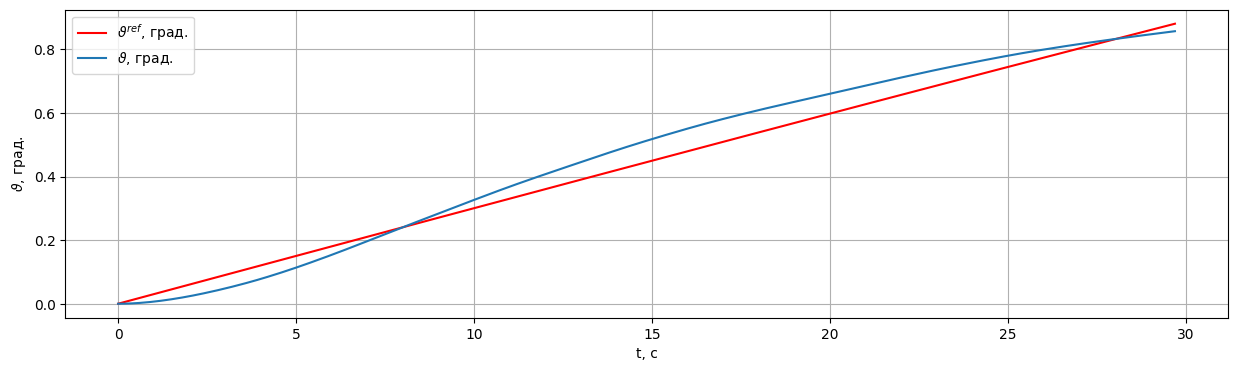

In [72]:
env.unwrapped.model.plot_transient_process('theta', tps, reference_signals[0], to_deg=True, figsize=(15,4))

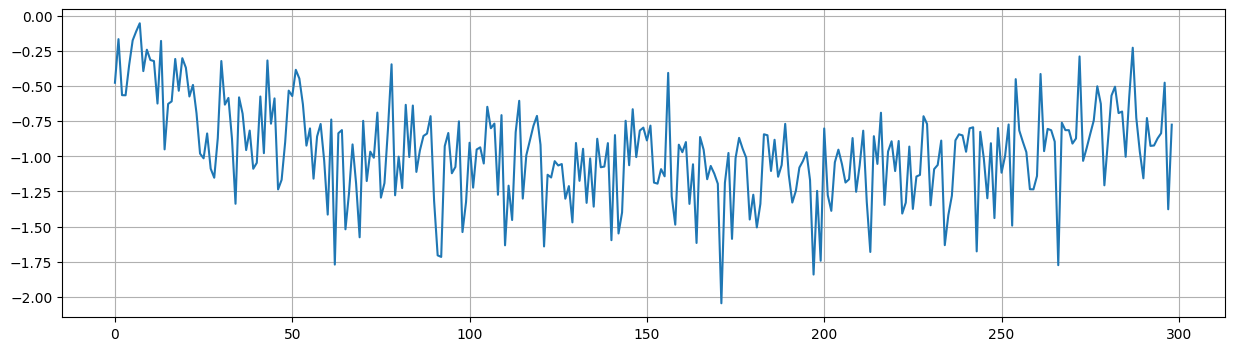

In [73]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,4))
plt.plot(cost_hist)
plt.grid(True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


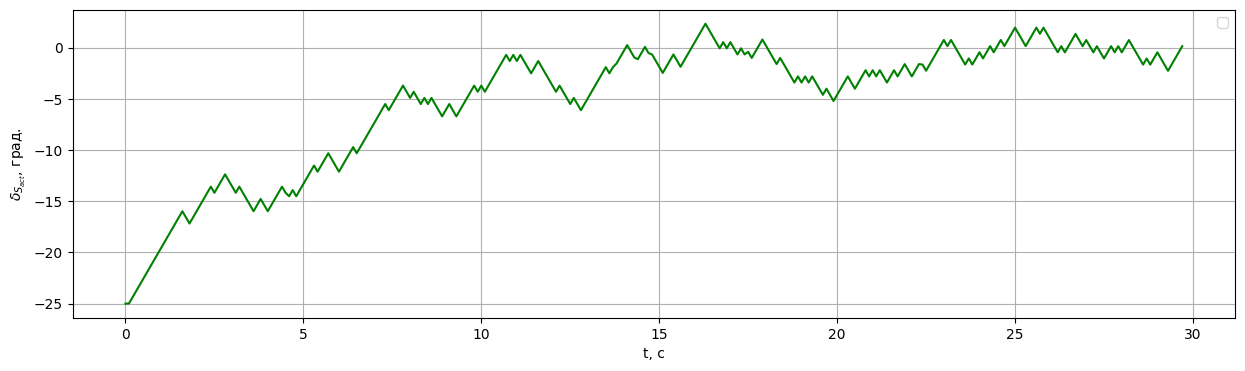

In [74]:
env.model.plot_control('ele', tps, to_deg=True, figsize=(15,4))

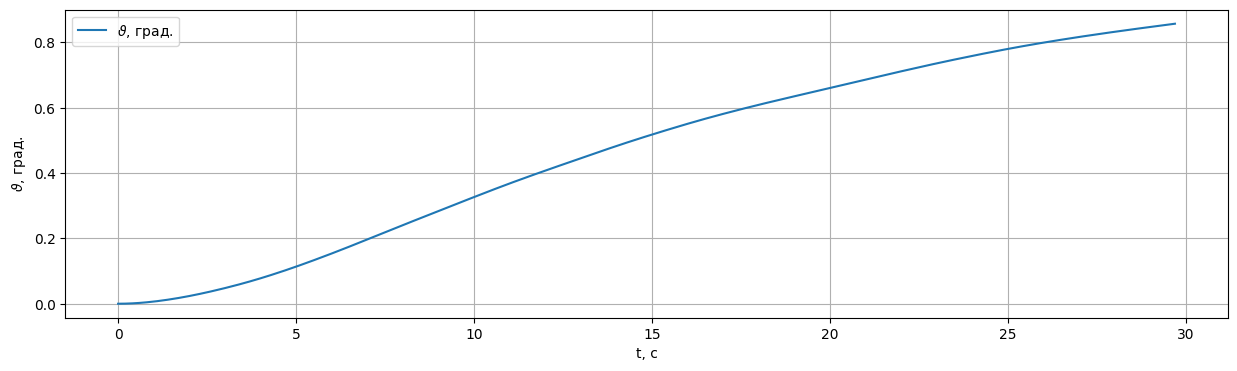

In [75]:
env.unwrapped.model.plot_state('theta', tps, figsize=(15,4), to_deg=True)

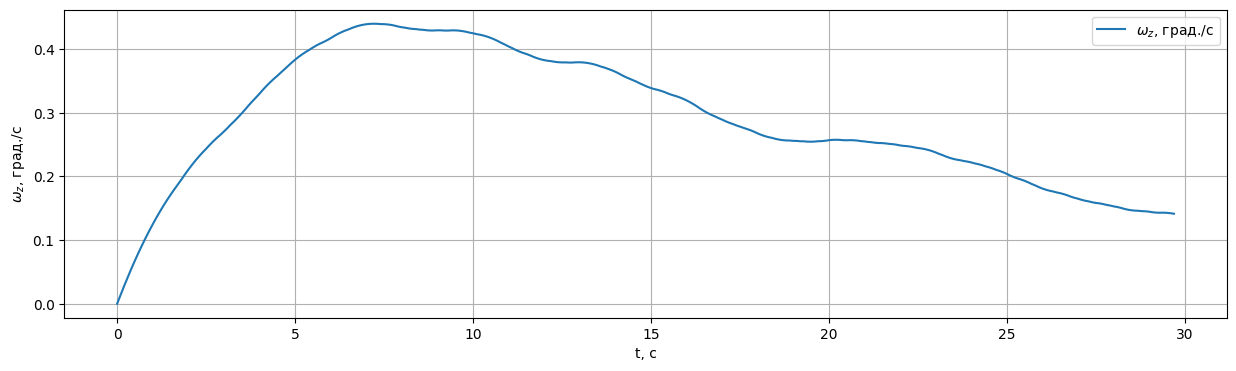

In [77]:
env.unwrapped.model.plot_state('q', tps, figsize=(15,4), to_deg=True)

In [78]:
st_e = static_error(reference_signals[0],env.unwrapped.model.get_state("theta", to_deg=True))
print("Статическая ошибка", st_e, "градуса")

Статическая ошибка -0.824148914394792 градуса
